# **Data Visualisation**

## Objectives

* Visually differentiate a healthy cherry leaf from one with powdery mildew.

## Inputs

* input/datasets/cherry_leaf_dataset/cherry-leaves/test
* input/datasets/cherry_leaf_dataset/cherry-leaves/train
* input/datasets/cherry_leaf_dataset/cherry-leaves/validation

## Outputs

* Count of images per class in train/validation/test
* Distribution plot of image widths and heights
* Per‑class mean & variability visualisations
* Difference map highlighting powdery mildew features
* Sample montages of healthy vs. mildew leaves

---

## Imports

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
sns.set_style("white")
from matplotlib.image import imread

## Change working directory

* We update the working directory as in Notebook 01.

In [2]:
current_dir = os.getcwd()
current_dir

'/workspaces/PP5-MildewDetection/jupyter_notebooks'

In [3]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [ ]:
current_dir = os.getcwd()
current_dir

'/workspaces/PP5-MildewDetection'

## Set Train, Validation and Test Paths

In [5]:
my_data_dir = 'input/datasets/cherry_leaf_dataset/cherry-leaves'
train_path = my_data_dir + '/train'
val_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'

## Set Output Directory

In [6]:
from pathlib import Path

# versioning & output directory
version = "v1"
base_out = Path("outputs") / version
figures_out = base_out / "figures"

# create folders if they don’t exist
figures_out.mkdir(parents=True, exist_ok=True)

print(f"Saving all figures into: {figures_out}")


Saving all figures into: outputs/v1/figures


## Set Label Names

In [7]:
labels = sorted(
    [p.name for p in Path(train_path).iterdir() if p.is_dir()]
)
print("Labels:", labels)

Labels: ['healthy', 'powdery_mildew']


---

# Visualisation of Image Data

---

## Class-count Summary - Ensuring Balance

* The below plots the number of images per class in each split (test, train, validate).
* If the bars are roughly the same height we can be confident our data is balanced.
* If there are significant discrepancies we may need to apply balancing techniques such as oversampling or undersampling.

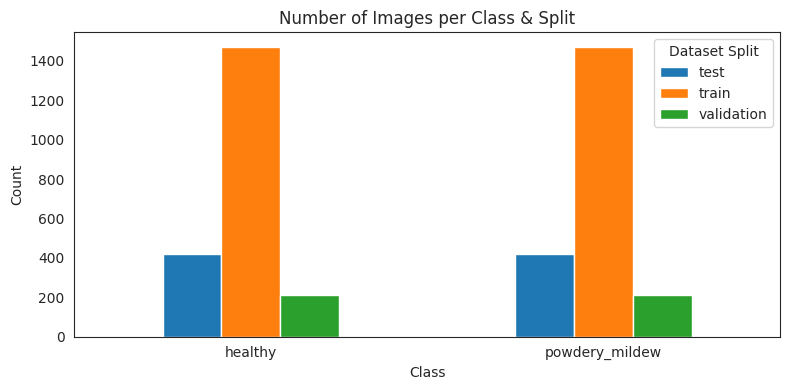

In [9]:
# Wrap inputs in Path to iterate over
train_dir = Path(train_path)
val_dir = Path(val_path)
test_dir = Path(test_path)

# Count images per class for each split
splits = {
    'train': train_dir,
    'validation': val_dir,
    'test': test_dir
}

# build counts
counts = []
for split_name, split_dir in splits.items():
    for cls in labels:
        n = len(list((split_dir/cls).glob('*')))  # count all files
        counts.append({'split': split_name, 'class': cls, 'count': n})

df_counts = pd.DataFrame(counts)

# pivot for plotting
df_pivot = df_counts.pivot(index='class', columns='split', values='count')

# plot
ax = df_pivot.plot(kind='bar', figsize=(8,4))
ax.set_title('Number of Images per Class & Split')
ax.set_xlabel('Class')
ax.set_ylabel('Count')
plt.xticks(rotation=0)
plt.legend(title='Dataset Split')
plt.tight_layout()

# save
plt.savefig(figures_out/'class_counts.png')
plt.show()

The bar chart confirms that both “healthy” and “powdery_mildew” classes are closely balanced across the train, validation, and test splits.

With class counts verified, we can proceed knowing our dataset isn’t biased by uneven class representation.

---

# Section 2

Section 2 content

---

NOTE

* You may add as many sections as you want, as long as it supports your project workflow.
* All notebook's cells should be run top-down (you can't create a dynamic wherein a given point you need to go back to a previous cell to execute some task, like go back to a previous cell and refresh a variable content)

---

# Push files to Repo

* If you don't need to push files to Repo, you may replace this section with "Conclusions and Next Steps" and state your conclusions and next steps.

In [ ]:
import os
try:
    # create here your folder
    # os.makedirs(name='')
except Exception as e:
    print(e)
